# 🐸 AnuraSet Audio Lab 1

**Data Exploration with Python**

Welcome! In this notebook we will review some Python fundamentals while exploring *AnuraSet*, a dataset of frog vocalizations.  

By the end you will be able to:

* manipulate CSV data with **pandas**
* visualize summaries with **matplotlib** and **seaborn**
* load & play audio clips with **librosa** / **IPython.display.Audio**
* plot spectrograms
* write a small object‑oriented wrapper for audio samples
* identify a frog species of your choosing using your own human brain! (Next time we will teach the machine)

Fill in the **📝 Exercise** sections. [NOTE: These are filled in with example solutions now; we can remove them before sending to students] 


In [ ]:
# ------------------------------------------------------------
# SETUP - Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import Audio, display, clear_output
import ipywidgets as widgets
import librosa
import random
import os

In [ ]:
# ------------------------------------------------------------
# DATA LOCATION - Change if you are using a different machine
# ------------------------------------------------------------
DATA_DIR = Path('/mnt/class_data/anuraset')
META_PATH = DATA_DIR / 'metadata.csv'
AUDIO_DIR = DATA_DIR / 'audio'

assert META_PATH.exists(), f"{META_PATH} does not exist. Update DATA_DIR!"


In [ ]:
# ------------------------------------------------------------
# 1 – Load & inspect metadata
# ------------------------------------------------------------
meta = pd.read_csv(META_PATH)
print(f"Loaded {len(meta):,} rows x {meta.shape[1]} columns")
meta.head()


Loaded 93,378 rows × 50 columns


,sample_name,fname,min_t,max_t,site,date,species_number,subset,SPHSUR,BOABIS,...,SCINAS,LEPNOT,ADEMAR,BOAALM,PHYDIS,RHIORN,LEPFLA,SCIRIZ,DENELE,SCIALT
0,SAMPLE_00000.wav,INCT20955_20190904_003000,0,3,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
1,SAMPLE_00001.wav,INCT20955_20190904_003000,1,4,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
2,SAMPLE_00002.wav,INCT20955_20190904_003000,2,5,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
3,SAMPLE_00003.wav,INCT20955_20190904_003000,3,6,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0
4,SAMPLE_00004.wav,INCT20955_20190904_003000,4,7,INCT20955,2019-09-04 00:30:00,4,test,1,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# ------------------------------------------------------------
# Species indicator columns
# ------------------------------------------------------------
# In AnuraSet each species has its own binary column (1 = species vocalization
# present in the 3‑second sample).  Let's grab just those columns.
species_cols = meta.columns[8:]   # first 8 columns are meta‑info
print(f"Detected {len(species_cols)} species columns")
species_cols[:10]


Detected 42 species columns


Index(['SPHSUR', 'BOABIS', 'SCIPER', 'DENNAH', 'LEPLAT', 'RHIICT', 'BOALEP',
       'BOAFAB', 'PHYCUV', 'DENMIN'],
      dtype='object')

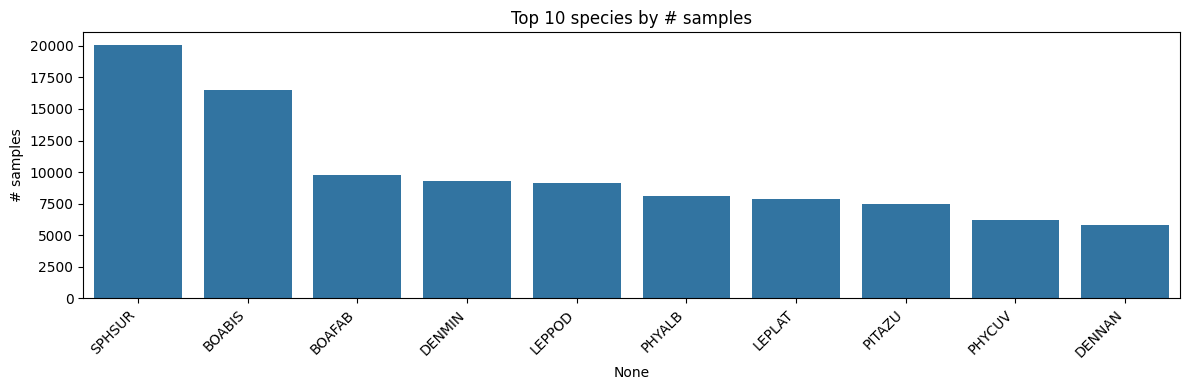

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 1 – Count how many samples for each species
# ------------------------------------------------------------
# Create a pandas Series mapping species → number of positive samples.
# Then plot the counts as a bar chart (top 10 species).
species_counts = None

# Example solution 
# ------------------------------------------------------------
species_counts = meta[species_cols].sum().sort_values(ascending=False)

top_n = 10
plt.figure(figsize=(12,4))
sns.barplot(x=species_counts.head(top_n).index,
            y=species_counts.head(top_n).values)
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {top_n} species by # samples')
plt.ylabel('# samples')
plt.tight_layout()


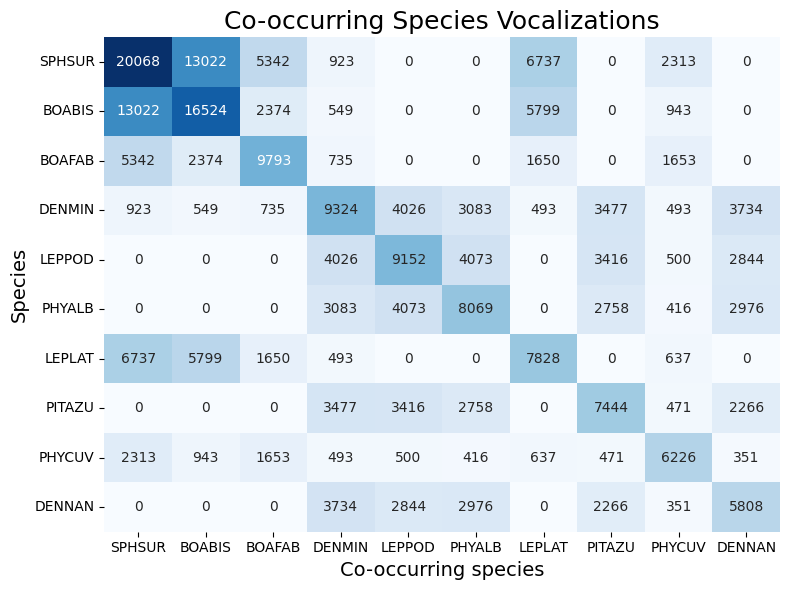

In [7]:
# 📝 Exercise 2? (Not sure if useful)
# Compute a co-occurrance matrix for the top 10 most prevalent species
# in the dataset and visualize it using a heatmap.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_species = species_counts[:10].index
confusion_matrix = meta[top_species].T.dot(meta[top_species])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Co-occurring Species Vocalizations',fontsize=18)
plt.xlabel('Co-occurring species', fontsize=14)
plt.ylabel('Species', fontsize=14)
plt.tight_layout()

In [8]:
# ------------------------------------------------------------
# Choose a target species - You will learn to classify it yourself!
# Pick a species code that interests you. Change TARGET below.
# ------------------------------------------------------------
TARGET = 'SPHSUR'  
assert TARGET in species_cols, f"{TARGET} not a valid column!"


In [9]:
# ------------------------------------------------------------
# 📝 Exercise 3 – Find recordings dominated by the target species.
# We will use these to help learn what that species sounds like. (It will be easier to learn from clips where they are mostly-alone)
#
# Filter the meta dataframe down to clips (i.e. rows) that satisfy two criteria: (1) they contain your TARGET species and (2) they contain 2 or fewer species total.
# Store the filtered dataframe as solo_df
solo_df = None

# Example solution
# ------------------------------------------------------------
solo_df = meta[(meta[TARGET]==1) & (meta['species_number'] <= 2)]
print(len(solo_df))
solo_df.head()


1769


,sample_name,fname,min_t,max_t,site,date,species_number,subset,SPHSUR,BOABIS,...,SCINAS,LEPNOT,ADEMAR,BOAALM,PHYDIS,RHIORN,LEPFLA,SCIRIZ,DENELE,SCIALT
118,SAMPLE_00118.wav,INCT20955_20190909_171500,2,5,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
119,SAMPLE_00119.wav,INCT20955_20190909_171500,3,6,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
120,SAMPLE_00120.wav,INCT20955_20190909_171500,4,7,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
121,SAMPLE_00121.wav,INCT20955_20190909_171500,5,8,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0
122,SAMPLE_00122.wav,INCT20955_20190909_171500,6,9,INCT20955,2019-09-09 17:15:00,2,train,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# ------------------------------------------------------------
# 📝 Exercise 4 - Load & play audio
# See if you can learn to recognize your chosen species!
# First, write a method that will load the file associated with any row of the meta dataframe.
# Example solution
# ------------------------------------------------------------
def filepath_from_row(row, data_loc='/mnt/class_data/anuraset/audio/'):
    return os.path.join(data_loc, row.site, "_".join([row.fname, str(row.min_t), str(row.max_t)]) + ".wav")

# Next, write a method to play the audio from a row of the dataframe
# Print the file path before playing (this will be useful later in Notebook 2)
# Hint: use librosa.load and IPython.display.Audio
def play_audio(row):
    fp = filepath_from_row(row)
    print(fp)
    audio, sr = librosa.load(fp, sr=None)
    display(Audio(audio, rate=sr))

# Now select 10 random clips from solo_df and play their audio using the methods you just wrote.
# See if you can identify patterns in the clips and begin to learn how to identify your target species.
# Example solution
# ------------------------------------------------------------
k = 10
print(str(k) + " " + TARGET + " samples:")
idxs = random.sample(list(range(len(solo_df))), k=k)
for idx in idxs:
    play_audio(solo_df.iloc[idx])
    

10 SPHSUR samples:
/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200327_191500_40_43.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200213_191500_47_50.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200314_231500_41_44.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20191031_180000_40_43.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20191215_184500_57_60.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200120_193000_14_17.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200325_194500_49_52.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20190909_171500_4_7.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200326_201500_5_8.wav


/mnt/class_data/anuraset/audio/INCT20955/INCT20955_20200326_200000_49_52.wav


In [ ]:
# Quiz yourself!
output = widgets.Output()

def audio_quiz():
    clear_output(wait=True)
    
    # Select one clip of the target species at random
    target_row = meta[(meta[TARGET] == 1)].sample(1).iloc[0]
    
    # Select one clip of a non-target species at random
    non_target_row = meta[(meta[TARGET] == 0)].sample(1).iloc[0]
    
    # Shuffle the two clips
    clips = [target_row, non_target_row]
    random.shuffle(clips)
    
    # Create quiz applet
    print("Listen to the two audio clips below and select the target species!")
    print("Target species:", TARGET)
    for i, clip in enumerate(clips):
        print(f"\nClip {i + 1}:")
        play_audio(clip)
    
    def on_button_click(button):
        clear_output(wait=True)
        if clips[int(button.description) - 1][TARGET] == 1:
            next_button = widgets.Button(description="CORRECT!! Try again?", layout=widgets.Layout(width='50%'))
        else:
            next_button = widgets.Button(description="WRONG!! Try again?", layout=widgets.Layout(width='50%'))
        
        next_button.on_click(lambda _: audio_quiz())  # Reset the quiz
        display(next_button)
    
    button1 = widgets.Button(description="1")
    button2 = widgets.Button(description="2")
    button1.on_click(on_button_click)
    button2.on_click(on_button_click)
    display(widgets.HBox([button1, button2]))

# Start the quiz
display(output)
audio_quiz()

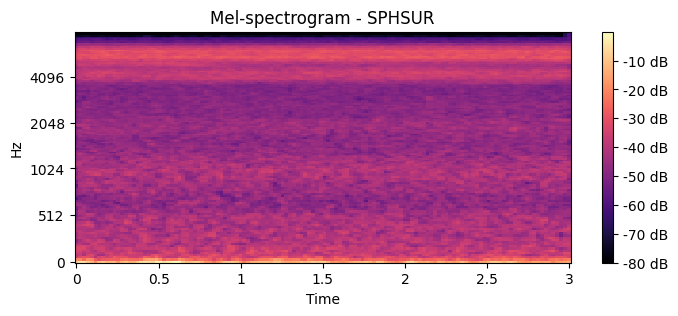

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 5 – Plot a spectrogram
# ------------------------------------------------------------
# Use librosa to convert `seg_audio` to a mel‑spectrogram and display it.
#
# Hints:
#   S = librosa.feature.melspectrogram(seg_audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
#   S_dB = librosa.power_to_db(S, ref=np.max)
#

# Example solution
# ------------------------------------------------------------
fp = filepath_from_row(solo_df.iloc[0]) # sample filepath
audio, sr = librosa.load(fp, sr=None)
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(8, 3))
librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-spectrogram - {TARGET}')
plt.show()

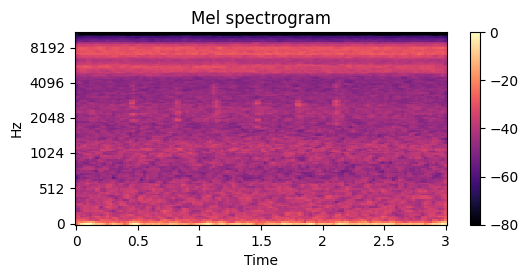

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 6 - Object oriented approach
#
# Example of something we could do that shows the value of caching things in the object... 
# but not sure what you have in mind here @tom
#
# ------------------------------------------------------------
from typing import Tuple, Optional

class AudioSample:
    def __init__(self, fp: Path):
        self.fp = fp
        self._audio = None
        self._sr = None

    def _path(self):
        return self.fp
    
    def load_audio(self):
        # Load and cache
        if self._audio is None:
            audio, sr = librosa.load(self._path(), sr=None)
            self._audio, self._sr = audio, sr
        return self._audio, self._sr
    
    def play(self, secs=None):
        audio, sr = self.load_audio()
        if secs is not None:
            audio = audio[:int(secs*sr)]
        display(Audio(audio, rate=sr))

    def plot_spectrogram(self):
        audio, sr = self.load_audio()
        S = librosa.feature.melspectrogram(y=audio, sr=sr)
        S_db = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(6,2.5))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(); plt.title('Mel spectrogram')


sample_file = AudioSample(filepath_from_row(solo_df.iloc[idx]))
sample_file.play()
sample_file.plot_spectrogram()

In [ ]:
# ------------------------------------------------------------
# Bonus – dataclass variant?
# ------------------------------------------------------------
from dataclasses import dataclass, field

# Convert AudioSample into a @dataclass named AudioClip
# with the same API as above?